# Data science takehome for Relax, Inc.

This notebook supports a Springboard practice takehome from a hypothetical company, Relax, Inc.  The takehome has two tasks:  

* Calculating 'adopted users' and 
* Evaluating what features predicted user adoption

# Set up

In [1]:
# Import key libraries
import numpy as np
import pandas as pd

## Import other libraries
import datetime
import chardet

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set some defaults for Seaborn
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

# Import sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# 1.  Calc adopted users

## Load

In [2]:
user_engagement_raw = pd.read_csv('data_raw_takehome_user_engagement.csv')

## Assess

In [3]:
user_engagement_raw.shape

(207917, 3)

In [4]:
user_engagement_raw.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_engagement_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
user_engagement_raw.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


## Explore

In [7]:
# Get some basic points of reference
print('There are {} unique users who visited'.format(len(user_engagement_raw.user_id.unique())))
print('The first visit by any users is on {}'.format(user_engagement_raw.time_stamp.min()))
print('The last visit by any users is on {}'.format(user_engagement_raw.time_stamp.max()))

There are 8823 unique users who visited
The first visit by any users is on 2012-05-31 08:20:06
The last visit by any users is on 2014-06-06 14:58:50


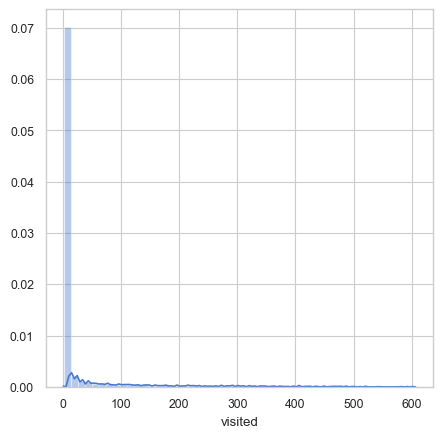

In [8]:
# Look at the distribution of visits per user
user_by_vists = user_engagement_raw.groupby('user_id')['visited'].sum()
g = plt.figure(figsize=(5, 5), dpi=100)
g = sns.distplot(user_by_vists)

## Calculate adopted user

My game plan is to:

* Build a data frame lists the visits of each user
* Loop through that data frame by user and calc whether the user was adopted (3 in 7 days)
* Make sure to add back in all the users who never visited

In [9]:
# Create new table
user_adop_temp = user_engagement_raw.copy()
user_adop_temp.drop(['visited'], axis=1, inplace=True)

# Create a column with 'visit_no' to make the pivot a bit easier
user_adop_temp['visit_order'] = user_adop_temp['time_stamp'].rank(method='dense') # Getting a numeric to rank within groupby
user_adop_temp.sort_values(by='time_stamp')
user_adop_temp['visit_no'] = user_adop_temp.groupby('user_id')['visit_order'].rank(method='dense')
user_adop_temp.drop(['visit_order'], axis=1, inplace=True)

# Creating a table of visit by user
visit_by_user = user_adop_temp.pivot(index='visit_no', columns='user_id', values='time_stamp')

In [10]:
visit_by_user.head(3)

user_id,1,2,3,4,5,6,7,10,11,13,...,11989,11990,11991,11992,11995,11996,11997,11998,11999,12000
visit_no,,,,,,,,,,,,,,,,,,,,,
1.0,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52,2013-05-22 08:09:28,2013-01-22 10:14:20,2013-12-19 03:37:06,2012-12-20 13:24:32,2013-01-16 22:08:03,2013-12-27 03:55:54,2014-03-30 16:19:38,...,2013-09-07 11:24:33,2013-07-06 21:00:48,2014-04-20 14:22:45,2014-04-11 19:39:56,2013-10-22 13:33:17,2013-09-06 06:14:15,2013-01-15 18:28:37,2014-04-27 12:45:16,2012-06-02 11:55:59,2014-01-26 08:57:12
2.0,NaN,2013-11-29 03:45:04,NaN,NaN,NaN,NaN,NaN,2013-01-22 22:08:03,NaN,NaN,...,NaN,NaN,2014-04-25 14:22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,2013-12-09 03:45:04,NaN,NaN,NaN,NaN,NaN,2013-01-30 22:08:03,NaN,NaN,...,NaN,NaN,2014-04-28 14:22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Set up some variables to be used in the loops
visits_max = visit_by_user.shape[0]
users_max = visit_by_user.shape[1]
adop_window = datetime.timedelta(days=7)
user_adop_ls = []

# Loop thru the dataframe
for user_no in range(users_max):
    is_adopted = False
    for visit_no in range(2, visits_max):
        current_visit = visit_by_user.iloc[visit_no, user_no]
        prior_visit = visit_by_user.iloc[(visit_no - 2), user_no]  
        if pd.isnull(current_visit):
            break
        diff = (pd.to_datetime(current_visit) - pd.to_datetime(prior_visit))
        if diff <= adop_window:
            is_adopted = True
            break
    user_adop_ls.append(is_adopted)
    
# Created a dataframe of adopted users from the resulting lists
adopted_user_partial = pd.DataFrame()
adopted_user_partial['user_id'] = visit_by_user.columns.tolist()
adopted_user_partial['adopted_user'] = user_adop_ls

# Set 'user_id' as index
adopted_user_partial = adopted_user_partial.set_index('user_id')

In [12]:
# Add in users who have id, who never visited and who, accordingly, can't be aopted users
# NOTE:  Use 'user_id' as index, not 0 based index

# List user_id that are missing from the raw user engagement file 
temp_ls_user_adopted = adopted_user_partial.index.tolist()
temp_ls_user_all = list(range(1, 12001))
temp_ls_user_missing = list(set(temp_ls_user_all) - set(temp_ls_user_adopted))

# Create a temp dataframe of missing user_id with false adopted values
temp = pd.DataFrame()
temp['user_id'] = temp_ls_user_missing
temp['adopted_user'] = False
temp = temp.set_index('user_id')

# Append the temp dataframe to adopted_user and sort it
adopted_user = adopted_user_partial.append(temp)
adopted_user.sort_index(axis = 0, inplace=True)

# Check:  Did I create any more adopted users?  I shouldn't have
assert adopted_user_partial['adopted_user'].sum()== adopted_user['adopted_user'].sum()

In [13]:
print('About {}% of all with user ID are adopted'.format((adopted_user['adopted_user'].sum() / adopted_user.shape[0]) * 100) )

About 13.8% of all with user ID are adopted


In [14]:
adopted_user['adopted_user'].value_counts()

False    10344
True      1656
Name: adopted_user, dtype: int64

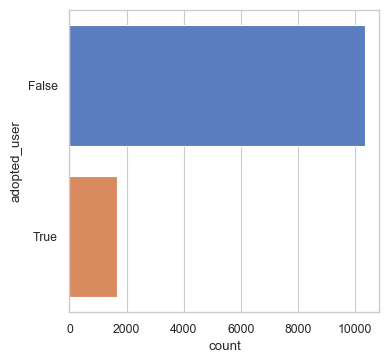

In [15]:
g = plt.figure(figsize=(4, 4), dpi=100)
g = sns.countplot(y='adopted_user', data=adopted_user)

# 2.  Examine predictive features

## Load

In [16]:
# Determine unicode after getting UnicodeDecodeError assuming the default of  UTF-8
with open('data_raw_takehome_users.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [17]:
# Read data
user_raw = pd.read_csv('data_raw_takehome_users.csv', encoding='ISO-8859-1')

## Assess

In [18]:
user_raw.shape

(12000, 10)

In [19]:
user_raw.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [20]:
user_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## Explore

In [21]:
# Examine values for 'creation_source'
user_raw['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [22]:
# Count values for 'creation_source'
user_raw['creation_source'].value_counts() 

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [23]:
# Count values for 'org_id'
user_raw.groupby('org_id')['object_id'].nunique()

org_id
0      319
1      233
2      201
3      168
4      159
      ... 
412     17
413     16
414     20
415     16
416      2
Name: object_id, Length: 417, dtype: int64

In [24]:
# Calc percent of users who were invited
temp = user_raw['invited_by_user_id'].notnull().sum() / len(user_raw['invited_by_user_id'])
print('The percent of users invited is {}'.format(temp * 100))

The percent of users invited is 53.474999999999994


## Prepare

Here, I clean up the user data and so some simple feature engineering.

In [25]:
user = user_raw.copy()

In [26]:
# Rename to 'user_id'
user = user.rename(columns={'object_id': 'user_id'})

# Set 'user_id' as index
user = user.set_index('user_id')

In [27]:
# Turn 'creation_time' into 'months_since_creation'
# Note:  Assume today's date is 7/1/2014, a few weeks after the last login
user['creation_time'] = pd.to_datetime(user['creation_time'])
NOW = pd.datetime(2014, 7, 1)
user['months_since_creation'] = (NOW - user['creation_time']) / np.timedelta64(1,'M')

# NOTE:  Drop original column of 'creation_time' after it's used in a later function

In [28]:
# Dummy encode creation source and adding columns back into table
# Note:  I will drop one category right before doing the logistic regression
user['creation_source'] = user['creation_source'].str.lower() 
dummies = pd.get_dummies(user['creation_source'],prefix='source', drop_first=False)
user = user.merge(dummies, left_index=True, right_index=True)

# Drop original column of 'creation_time'
user.drop(['creation_source'], axis=1, inplace=True)

In [29]:
# Drop orignal colum of 'name'
user.drop(['name'], axis=1, inplace=True)

In [30]:
# Turn 'email' into 'top_level_domain_category' to indicate .com or .de

# Extract top-level domain
tld = user['email'].str.split('@').str[1].str.split('.').str[1]
user['top_level_domain'] = tld 

# Categorize top-level domain
def categorize_tld(value_top_level_domain):
    tld_category = 0
    if value_top_level_domain == 'de':
        tld_category = 1
    return tld_category

# Create new column with the function
user['top_level_domain_category'] = user.apply(lambda x: categorize_tld(x['top_level_domain']), axis=1)

In [31]:
# Turn 'email' into 'second_level_domain_category' to indicate if sld is personal email provider (like gmail)

# Extract second-level domain
sld = user['email'].str.split('@').str[1].str.split('.').str[0]
user['second_level_domain'] = sld

# Categorize second-level domain
def categorize_sld(value_second_level_domain):
    major_personal_email_ls = ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']
    sld_category = 0
    if value_second_level_domain not in major_personal_email_ls:
        sld_category = 1
    return sld_category

# Create new column with the function
user['second_level_domain_category'] = user.apply(lambda x: categorize_sld(x['second_level_domain']), axis=1)

# Drop orignal columns and temp columns
user.drop(['email', 'top_level_domain', 'second_level_domain'], axis=1, inplace=True)

In [32]:
# Turn 'last_session_creation_time' into 'months_since_last_session'

# Convert last session from unix epoc time to datetime
user['last_session_creation_time'] = pd.to_datetime(user['last_session_creation_time'], unit = "s") 

# Define function to calc months_since_last_sessoin
def calc_mo_since_last_session(value_last_session_creation_time, value_creation_time):
    NOW = pd.datetime(2014, 7, 1)
    if pd.isnull(value_last_session_creation_time):
        months_since_last_session = 100
    else:
        months_since_last_session = (NOW - value_last_session_creation_time) / np.timedelta64(1,'M')
    return months_since_last_session

# Create new column with the function
user['months_since_last_session'] = user.apply(lambda x: calc_mo_since_last_session(x['last_session_creation_time'], 
                                                                 x['creation_time']), axis=1)
# Drop original columns
user.drop(['creation_time'], axis=1, inplace=True)
user.drop(['last_session_creation_time'], axis=1, inplace=True)

# NOTE:  How best to encode, User never accessed?  I will use a fixed value of 100

In [33]:
# Convert 'org_id' into 'member_of_an_org'
# Assumes org_id of 0 means no org and all other values are specific orgs

# Define function to calc if member of an org
def calc_member_of_org(value_org_id):
    is_member = 1
    if value_org_id == 0:
        is_member = 0
    return is_member

# Create new column with the function
user['member_of_an_org'] = user.apply(lambda x: calc_member_of_org(x['org_id']), axis=1)

# Drop orignal column
user.drop(['org_id'], axis=1, inplace=True)

In [34]:
# Convert 'invited_by_user_id' into 'invited'

# Define function to calc yes invited if there's invited_by_user_id
def invited(value_of_invited_by_user_id):
    is_invited = 1
    if pd.isnull(value_of_invited_by_user_id):
        is_invited = 0
    return is_invited

# Create new column with the function
user['invited'] = user.apply(lambda x: invited(x['invited_by_user_id']), axis=1)

# Drop orignal column 
user.drop(['invited_by_user_id'], axis=1, inplace=True)

# Check 
assert user_raw['invited_by_user_id'].count() == user['invited'].sum()

In [35]:
# Add a column of random 1's and 0's as a point of comparison
user['random'] = np.random.randint(low=0, high=2, size=user.shape[0])

## Further explore

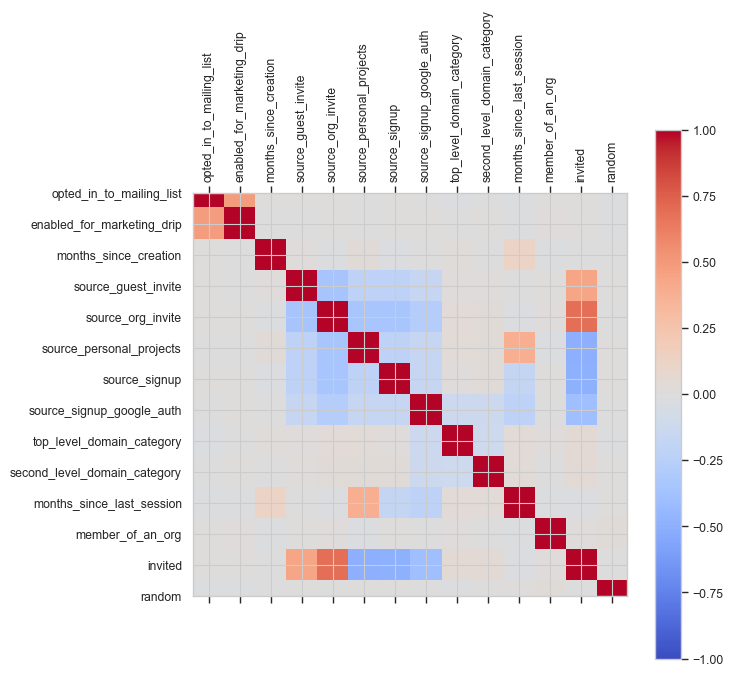

In [36]:
# Look at correlation between new features
corr = user.corr()
fig = plt.figure(figsize=(7, 7), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(user.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(user.columns)
ax.set_yticklabels(user.columns)
plt.show()

## Model adopted users with random forest

In [37]:
# Assign
y = adopted_user
X = user

In [38]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
# Instantiate
rf_baseline=RandomForestClassifier(n_estimators=100, oob_score = True)

In [40]:
# Fit
rf_baseline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(oob_score=True)

In [41]:
# Summarize
rf_baseline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [42]:
# Predict
y_pred = rf_baseline.predict(X_test)

In [43]:
# Score
print('The accuracy score is {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('The oob score {}'.format(rf_baseline.oob_score_))

The accuracy score is 0.962
The oob score 0.9628888888888889


In [44]:
# Exmaine confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[2555   25]
 [  89  331]]


In [45]:
# Examine precision, recall and F1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      2580
        True       0.93      0.79      0.85       420

    accuracy                           0.96      3000
   macro avg       0.95      0.89      0.92      3000
weighted avg       0.96      0.96      0.96      3000



No handles with labels found to put in legend.


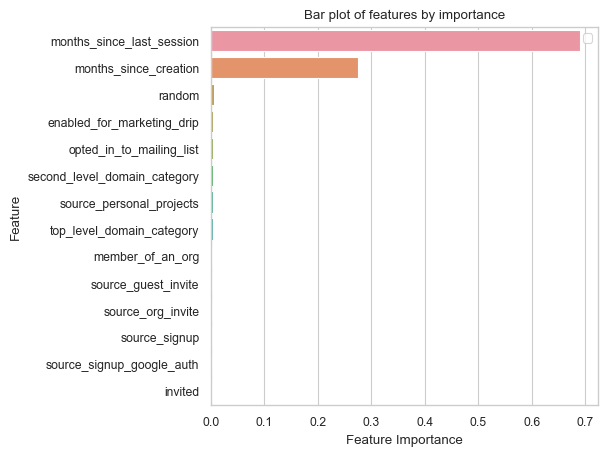

In [46]:
# Visualize feature importance
feature_imp = pd.Series(rf_baseline.feature_importances_,index=user.columns.tolist()).sort_values(ascending=False)
g = plt.figure(figsize=(5, 5), dpi=100)
g = sns.barplot(x=feature_imp, y=feature_imp.index)
g = plt.xlabel('Feature Importance')
g = plt.ylabel('Feature')
g = plt.title("Bar plot of features by importance")
g = plt.legend()

In [47]:
# Create summary table
rf_coeff = pd.DataFrame()
rf_coeff['features'] = X_train.columns
rf_coeff['rf_importance'] = rf_baseline.feature_importances_.round(4)
rf_coeff['rf_rank'] = rf_coeff['rf_importance'].rank(method='dense', ascending=False).astype('int32')

# Call out the magnitude of the feature's importance to the rf model
def calc_rf_magnitude(value_rf_importance):
    if value_rf_importance >= 0.25:
        size = 'high'
    elif value_rf_importance > .003 and value_rf_importance < 0.25:
        size = 'med'
    else:
        size = 'low'
    return size

# Create new column with the function
rf_coeff['rf_magnitude'] = rf_coeff.apply(lambda x: calc_rf_magnitude(x['rf_importance']), axis=1)

# rf_coeff.sort_values(by='rf_coeff', ascending=True)

## Model adopted users with logistic regression

### Further prep

In [48]:
# Scale two columns
user_scaled_temp = user.copy()
user_scaled_col = ['months_since_creation', 'months_since_last_session']
user_scaled_features = user_scaled_temp[user_scaled_col]
scaler = StandardScaler().fit(user_scaled_features.values)
user_scaled_features = scaler.transform(user_scaled_features.values)
user_scaled_temp[user_scaled_col] = user_scaled_features
user_scaled_2 = pd.DataFrame(data=user_scaled_temp, columns=user.columns.tolist(), index=user.index.values)

In [49]:
# Drop most common 'source' dummy variable (i.e, 'org_invite') for logistic regresson
user_scaled_2.drop(['source_org_invite'], axis=1, inplace=True)

### Model

In [50]:
# Assign
y = adopted_user
X = user_scaled_2

In [51]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
# Instantiate
logit = LogisticRegression(fit_intercept = False)

In [53]:
# Fit
logit.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(fit_intercept=False)

In [54]:
# Summarize
logit.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': False,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [55]:
# Predict 
y_pred = logit.predict(X_test)

In [56]:
# Score
print('The accuracy score is {}'.format(metrics.accuracy_score(y_test, y_pred)))

The accuracy score is 0.9473333333333334


In [57]:
# Examine confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[2580    0]
 [ 158  262]]


In [58]:
# Examine precision, recall and F1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      1.00      0.97      2580
        True       1.00      0.62      0.77       420

    accuracy                           0.95      3000
   macro avg       0.97      0.81      0.87      3000
weighted avg       0.95      0.95      0.94      3000



In [59]:
# Create summary table
logit_coeff = pd.DataFrame()
logit_coeff['features'] = X_train.columns
logit_coeff['logit_coeff'] = logit.coef_[0].round(3)
logit_coeff['logit_coeff_abs'] = pd.Series(logit.coef_[0]).abs().round(3)
logit_coeff['logit_rank'] = logit_coeff['logit_coeff_abs'].rank(method='dense', ascending=False).astype('int32')

# Call out the direction of the change in the logit coefficient
def calc_logit_direction(value_logit_coeff):
    direction = 'positive' 
    if value_logit_coeff < 0:
        direction = 'negative'
    return direction

# Create new column with the function
logit_coeff['logit_direction'] = logit_coeff.apply(lambda x: calc_logit_direction(x['logit_coeff']), axis=1)

# Call out the magnitude of logit coefficient
def calc_logit_magnitude(logit_coeff_abs):
    if logit_coeff_abs >= 5:
        size = 'high'
    elif logit_coeff_abs > 1 and logit_coeff_abs < 5:
        size = 'med'
    else:
        size = 'low'
    return size

# Create new column with the function
logit_coeff['logit_magnitude'] = logit_coeff.apply(lambda x: calc_logit_magnitude(x['logit_coeff_abs']), axis=1)

# Drop temp colum
logit_coeff.drop(['logit_coeff_abs'], axis=1, inplace=True)

In [60]:
# Combine rf and logit summaries into single table
final_coeff = pd.merge(rf_coeff, logit_coeff, on='features', how='outer')
final_coeff.sort_values(by='rf_rank')

,features,rf_importance,rf_rank,rf_magnitude,logit_coeff,logit_rank,logit_direction,logit_magnitude
10,months_since_last_session,0.6901,1,high,-16.971,1.0,negative,high
2,months_since_creation,0.2744,2,high,2.777,6.0,positive,med
13,random,0.0064,3,med,-0.122,9.0,negative,low
0,opted_in_to_mailing_list,0.0047,4,med,-0.041,10.0,negative,low
1,enabled_for_marketing_drip,0.0047,4,med,-0.011,13.0,negative,low
9,second_level_domain_category,0.0035,5,med,-0.027,12.0,negative,low
5,source_personal_projects,0.0034,6,med,-10.014,5.0,negative,high
8,top_level_domain_category,0.0030,7,low,-0.040,11.0,negative,low
11,member_of_an_org,0.0020,8,low,-1.307,7.0,negative,med
3,source_guest_invite,0.0019,9,low,0.209,8.0,positive,low
